In [ ]:
%load_ext autoreload
%autoreload 2

from lib.megadepth_dataset import *
from externals.d2net.lib.utils import *

import numpy as np
import matplotlib.pyplot as plt
import cv2

from lib.attention_model import attention_model

from pathlib import Path 


In [2]:
megadepth_path = Path("/mnt/c/Users/phill/polybox/Deep Learning/MegaDepthDataset/")
scene_info_path = megadepth_path / "scene_info/"
scene_list = megadepth_path / "valid_scenes.txt"



In [3]:
dataset = MegaDepthDataset(base_path = megadepth_path, scene_info_path=scene_info_path, scene_list_path=scene_list)


In [4]:
dataset.build_dataset()

  0%|          | 0/1 [00:00<?, ?it/s]

Building a new training dataset...


100%|██████████| 1/1 [00:06<00:00,  6.19s/it]


In [5]:
print("Num Correspondences:", len(dataset.dataset))

Num Correspondences: 100


In [6]:
metadata = dataset.dataset[10]


In [7]:
correspondence = dataset[10]

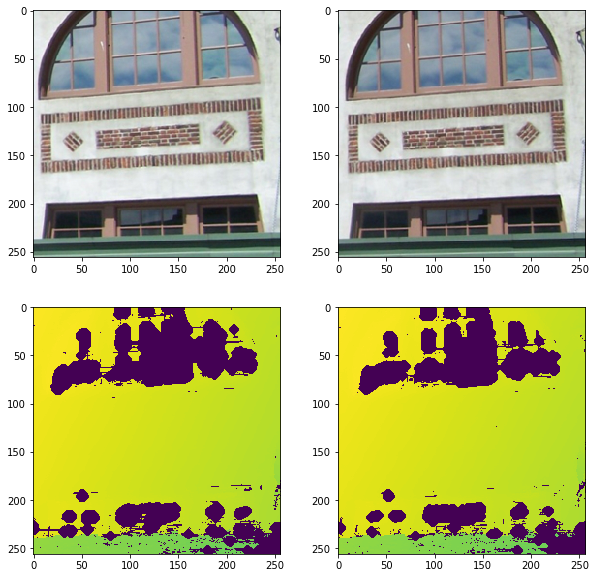

In [8]:
fig, axes = plt.subplots(2,2, figsize=(10,10))

axes[0][0].imshow(correspondence["image1"].permute(1,2,0) / 255.0)
axes[0][1].imshow(correspondence["image2"].permute(1,2,0) / 255.0)
axes[1][0].imshow(correspondence["depth1"]/ 255.0)
axes[1][1].imshow(correspondence["depth2"] / 255.0)


In [9]:
correspondence

{'image1': tensor([[[222., 222., 226.,  ..., 214., 214., 211.],
          [219., 220., 223.,  ..., 213., 211., 206.],
          [222., 222., 222.,  ..., 211., 208., 207.],
          ...,
          [ 97.,  98.,  98.,  ..., 117., 119., 116.],
          [140., 144., 144.,  ..., 115., 116., 115.],
          [169., 171., 170.,  ..., 115., 116., 114.]],
 
         [[231., 231., 232.,  ..., 219., 219., 217.],
          [230., 229., 229.,  ..., 218., 216., 212.],
          [231., 231., 231.,  ..., 216., 213., 213.],
          ...,
          [124., 125., 125.,  ..., 152., 153., 153.],
          [164., 167., 168.,  ..., 155., 155., 154.],
          [191., 191., 192.,  ..., 157., 155., 152.]],
 
         [[228., 228., 232.,  ..., 213., 213., 213.],
          [226., 228., 229.,  ..., 212., 212., 208.],
          [228., 230., 230.,  ..., 210., 209., 209.],
          ...,
          [105., 106., 106.,  ..., 132., 136., 136.],
          [148., 151., 152.,  ..., 131., 136., 136.],
          [178., 179.

In [15]:
batch = correspondence
depth1 = batch['depth1']  # [h1, w1]
intrinsics1 = batch['intrinsics1'] # [3, 3]
pose1 = batch['pose1'].view(4, 4)  # [4, 4]
bbox1 = batch['bbox1']  # [2]

depth2 = batch['depth2']
intrinsics2 = batch['intrinsics2']
pose2 = batch['pose2'].view(4, 4)
bbox2 = batch['bbox2']

# Network output
    attentions_1 = attentions1[idx_in_batch]
    c, h1, w1 = attentions_1.size()
    scores1 = output['scores1'][idx_in_batch].view(-1)

    dense_features2 = output['dense_features2'][idx_in_batch]
    _, h2, w2 = dense_features2.size()
    scores2 = output['scores2'][idx_in_batch]

fmap_pos1 = grid_positions(h1, w1, device)
pos1 = upscale_positions(fmap_pos1, scaling_steps=scaling_steps)
try:
    pos1, pos2, ids = warp(
        pos1,
        depth1, intrinsics1, pose1, bbox1,
        depth2, intrinsics2, pose2, bbox2
    )
except EmptyTensorError:
    continue
fmap_pos1 = fmap_pos1[:, ids]
descriptors1 = descriptors1[:, ids]
scores1 = scores1[ids]

# Skip the pair if not enough GT correspondences are available
if ids.size(0) < 128:
    continue

In [ ]:
loss = torch.tensor(np.array([0], dtype=np.float32), device=device)
    has_grad = False

    n_valid_samples = 0
    for idx_in_batch in range(batch['image1'].size(0)):
        # Annotations
        depth1 = batch['depth1'][idx_in_batch].to(device)  # [h1, w1]
        intrinsics1 = batch['intrinsics1'][idx_in_batch].to(device)  # [3, 3]
        pose1 = batch['pose1'][idx_in_batch].view(4, 4).to(device)  # [4, 4]
        bbox1 = batch['bbox1'][idx_in_batch].to(device)  # [2]

        depth2 = batch['depth2'][idx_in_batch].to(device)
        intrinsics2 = batch['intrinsics2'][idx_in_batch].to(device)
        pose2 = batch['pose2'][idx_in_batch].view(4, 4).to(device)
        bbox2 = batch['bbox2'][idx_in_batch].to(device)

        # Network output
        dense_features1 = output['dense_features1'][idx_in_batch]
        c, h1, w1 = dense_features1.size()
        scores1 = output['scores1'][idx_in_batch].view(-1)

        dense_features2 = output['dense_features2'][idx_in_batch]
        _, h2, w2 = dense_features2.size()
        scores2 = output['scores2'][idx_in_batch]

        all_descriptors1 = F.normalize(dense_features1.view(c, -1), dim=0)
        descriptors1 = all_descriptors1

        all_descriptors2 = F.normalize(dense_features2.view(c, -1), dim=0)

        # Warp the positions from image 1 to image 2
        fmap_pos1 = grid_positions(h1, w1, device)
        pos1 = upscale_positions(fmap_pos1, scaling_steps=scaling_steps)
        try:
            pos1, pos2, ids = warp(
                pos1,
                depth1, intrinsics1, pose1, bbox1,
                depth2, intrinsics2, pose2, bbox2
            )
        except EmptyTensorError:
            continue
        fmap_pos1 = fmap_pos1[:, ids]
        descriptors1 = descriptors1[:, ids]
        scores1 = scores1[ids]

        # Skip the pair if not enough GT correspondences are available
        if ids.size(0) < 128:
            continue

        # Descriptors at the corresponding positions
        fmap_pos2 = torch.round(
            downscale_positions(pos2, scaling_steps=scaling_steps)
        ).long()
        descriptors2 = F.normalize(
            dense_features2[:, fmap_pos2[0, :], fmap_pos2[1, :]],
            dim=0
        )
        positive_distance = 2 - 2 * (
            descriptors1.t().unsqueeze(1) @ descriptors2.t().unsqueeze(2)
        ).squeeze()

        all_fmap_pos2 = grid_positions(h2, w2, device)
        position_distance = torch.max(
            torch.abs(
                fmap_pos2.unsqueeze(2).float() -
                all_fmap_pos2.unsqueeze(1)
            ),
            dim=0
        )[0]
        is_out_of_safe_radius = position_distance > safe_radius
        distance_matrix = 2 - 2 * (descriptors1.t() @ all_descriptors2)
        negative_distance2 = torch.min(
            distance_matrix + (1 - is_out_of_safe_radius.float()) * 10.,
            dim=1
        )[0]

        all_fmap_pos1 = grid_positions(h1, w1, device)
        position_distance = torch.max(
            torch.abs(
                fmap_pos1.unsqueeze(2).float() -
                all_fmap_pos1.unsqueeze(1)
            ),
            dim=0
        )[0]
        is_out_of_safe_radius = position_distance > safe_radius
        distance_matrix = 2 - 2 * (descriptors2.t() @ all_descriptors1)
        negative_distance1 = torch.min(
            distance_matrix + (1 - is_out_of_safe_radius.float()) * 10.,
            dim=1
        )[0]

        diff = positive_distance - torch.min(
            negative_distance1, negative_distance2
        )

        scores2 = scores2[fmap_pos2[0, :], fmap_pos2[1, :]]

        loss = loss + (
            torch.sum(scores1 * scores2 * F.relu(margin + diff)) /
            torch.sum(scores1 * scores2)
        )

        has_grad = True
        n_valid_samples += 1

        if plot and batch['batch_idx'] % batch['log_interval'] == 0:
            pos1_aux = pos1.cpu().numpy()
            pos2_aux = pos2.cpu().numpy()
            k = pos1_aux.shape[1]
            col = np.random.rand(k, 3)
            n_sp = 4
            plt.figure()
            plt.subplot(1, n_sp, 1)
            im1 = imshow_image(
                batch['image1'][idx_in_batch].cpu().numpy(),
                preprocessing=batch['preprocessing']
            )
            plt.imshow(im1)
            plt.scatter(
                pos1_aux[1, :], pos1_aux[0, :],
                s=0.25**2, c=col, marker=',', alpha=0.5
            )
            plt.axis('off')
            plt.subplot(1, n_sp, 2)
            plt.imshow(
                output['scores1'][idx_in_batch].data.cpu().numpy(),
                cmap='Reds'
            )
            plt.axis('off')
            plt.subplot(1, n_sp, 3)
            im2 = imshow_image(
                batch['image2'][idx_in_batch].cpu().numpy(),
                preprocessing=batch['preprocessing']
            )
            plt.imshow(im2)
            plt.scatter(
                pos2_aux[1, :], pos2_aux[0, :],
                s=0.25**2, c=col, marker=',', alpha=0.5
            )
            plt.axis('off')
            plt.subplot(1, n_sp, 4)
            plt.imshow(
                output['scores2'][idx_in_batch].data.cpu().numpy(),
                cmap='Reds'
            )
            plt.axis('off')
            savefig('train_vis/%s.%02d.%02d.%d.png' % (
                'train' if batch['train'] else 'valid',
                batch['epoch_idx'],
                batch['batch_idx'] // batch['log_interval'],
                idx_in_batch
            ), dpi=300)
            plt.close()

    if not has_grad:
        raise NoGradientError

    loss = loss / n_valid_samples

    return loss


def interpolate_depth(pos, depth):
    device = pos.device

    ids = torch.arange(0, pos.size(1), device=device)

    h, w = depth.size()

    i = pos[0, :]
    j = pos[1, :]

    # Valid corners
    i_top_left = torch.floor(i).long()
    j_top_left = torch.floor(j).long()
    valid_top_left = torch.min(i_top_left >= 0, j_top_left >= 0)

    i_top_right = torch.floor(i).long()
    j_top_right = torch.ceil(j).long()
    valid_top_right = torch.min(i_top_right >= 0, j_top_right < w)

    i_bottom_left = torch.ceil(i).long()
    j_bottom_left = torch.floor(j).long()
    valid_bottom_left = torch.min(i_bottom_left < h, j_bottom_left >= 0)

    i_bottom_right = torch.ceil(i).long()
    j_bottom_right = torch.ceil(j).long()
    valid_bottom_right = torch.min(i_bottom_right < h, j_bottom_right < w)

    valid_corners = torch.min(
        torch.min(valid_top_left, valid_top_right),
        torch.min(valid_bottom_left, valid_bottom_right)
    )

    i_top_left = i_top_left[valid_corners]
    j_top_left = j_top_left[valid_corners]

    i_top_right = i_top_right[valid_corners]
    j_top_right = j_top_right[valid_corners]

    i_bottom_left = i_bottom_left[valid_corners]
    j_bottom_left = j_bottom_left[valid_corners]

    i_bottom_right = i_bottom_right[valid_corners]
    j_bottom_right = j_bottom_right[valid_corners]

    ids = ids[valid_corners]
    if ids.size(0) == 0:
        raise EmptyTensorError

    # Valid depth
    valid_depth = torch.min(
        torch.min(
            depth[i_top_left, j_top_left] > 0,
            depth[i_top_right, j_top_right] > 0
        ),
        torch.min(
            depth[i_bottom_left, j_bottom_left] > 0,
            depth[i_bottom_right, j_bottom_right] > 0
        )
    )

    i_top_left = i_top_left[valid_depth]
    j_top_left = j_top_left[valid_depth]

    i_top_right = i_top_right[valid_depth]
    j_top_right = j_top_right[valid_depth]

    i_bottom_left = i_bottom_left[valid_depth]
    j_bottom_left = j_bottom_left[valid_depth]

    i_bottom_right = i_bottom_right[valid_depth]
    j_bottom_right = j_bottom_right[valid_depth]

    ids = ids[valid_depth]
    if ids.size(0) == 0:
        raise EmptyTensorError

    # Interpolation
    i = i[ids]
    j = j[ids]
    dist_i_top_left = i - i_top_left.float()
    dist_j_top_left = j - j_top_left.float()
    w_top_left = (1 - dist_i_top_left) * (1 - dist_j_top_left)
    w_top_right = (1 - dist_i_top_left) * dist_j_top_left
    w_bottom_left = dist_i_top_left * (1 - dist_j_top_left)
    w_bottom_right = dist_i_top_left * dist_j_top_left

    interpolated_depth = (
        w_top_left * depth[i_top_left, j_top_left] +
        w_top_right * depth[i_top_right, j_top_right] +
        w_bottom_left * depth[i_bottom_left, j_bottom_left] +
        w_bottom_right * depth[i_bottom_right, j_bottom_right]
    )

    pos = torch.cat([i.view(1, -1), j.view(1, -1)], dim=0)

    return [interpolated_depth, pos, ids]


def uv_to_pos(uv):
    return torch.cat([uv[1, :].view(1, -1), uv[0, :].view(1, -1)], dim=0)


def warp(
        pos1,
        depth1, intrinsics1, pose1, bbox1,
        depth2, intrinsics2, pose2, bbox2
):
    device = pos1.device

    Z1, pos1, ids = interpolate_depth(pos1, depth1)

    # COLMAP convention
    u1 = pos1[1, :] + bbox1[1] + .5
    v1 = pos1[0, :] + bbox1[0] + .5

    X1 = (u1 - intrinsics1[0, 2]) * (Z1 / intrinsics1[0, 0])
    Y1 = (v1 - intrinsics1[1, 2]) * (Z1 / intrinsics1[1, 1])

    XYZ1_hom = torch.cat([
        X1.view(1, -1),
        Y1.view(1, -1),
        Z1.view(1, -1),
        torch.ones(1, Z1.size(0), device=device)
    ], dim=0)
    XYZ2_hom = torch.chain_matmul(pose2, torch.inverse(pose1), XYZ1_hom)
    XYZ2 = XYZ2_hom[: -1, :] / XYZ2_hom[-1, :].view(1, -1)

    uv2_hom = torch.matmul(intrinsics2, XYZ2)
    uv2 = uv2_hom[: -1, :] / uv2_hom[-1, :].view(1, -1)

    u2 = uv2[0, :] - bbox2[1] - .5
    v2 = uv2[1, :] - bbox2[0] - .5
    uv2 = torch.cat([u2.view(1, -1),  v2.view(1, -1)], dim=0)

    annotated_depth, pos2, new_ids = interpolate_depth(uv_to_pos(uv2), depth2)

    ids = ids[new_ids]
    pos1 = pos1[:, new_ids]
    estimated_depth = XYZ2[2, new_ids]

    inlier_mask = torch.abs(estimated_depth - annotated_depth) < 0.05

    ids = ids[inlier_mask]
    if ids.size(0) == 0:
        raise EmptyTensorError

    pos2 = pos2[:, inlier_mask]
    pos1 = pos1[:, inlier_mask]

    return pos1, pos2, ids